### Imports

In [72]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import anonypy

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score

## Useful links


Anonymisation:

    - https://lajavaness.medium.com/tout-sur-lanonymat-4-4-anonymiser-les-donn%C3%A9es-sans-perdre-d-information-le-compromis-b5d1efba8128,   
    - https://en.wikipedia.org/wiki/K-anonymity,
    - https://github.com/glassonion1/anonypy,


License:

    - https://choosealicense.com/licenses/,

## Exploring

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| balance | average yearly balance, in euros  |
| housing | has housing loan? |
| loan | has personal loan? |
| contact | contact communication |
| month | last contact month of year |
| day_of_week | last contact day of the week |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

## Functions

In [82]:
# Anonymiser
def anonymisator(df, categorical_features, numerical_features, target_column, k):
    df_anonym = df.copy()
    
    # Convert categorical features and target column to category dtype
    for name in set((categorical_features)):
        df_anonym[name] = df_anonym[name].astype("category")
    
    # Anonymize numerical values
    p = anonypy.Preserver(df, numerical_features, target_column)
    rows = p.anonymize_k_anonymity(k=k)
    
    dfn = pd.DataFrame(rows)
    
    return dfn

# Ungroupping results of the anonym
def ungroup_by_count(df):
    new_rows = []
    for index, row in df.iterrows():
        count = row['count']
        new_rows.extend([row.drop('count')] * count) 
    return pd.DataFrame(new_rows).reset_index(drop=True)

# Plot y_pred, y_true
def plot_classification_results(y_true, y_pred, classifier_name=None):
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {classifier_name}')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    tick_marks = [0, 1]
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

    print(f"Classification Report for {classifier_name}:")
    print(classification_report(y_true, y_pred))

# Subplots of the results 
def plot_classification_results_subplots(results, classifier_names):

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()

    precisions = []
    f1_scores = []
    recalls = []

    for idx, (y_true, y_pred) in enumerate(results):
        cm = confusion_matrix(y_true, y_pred)

        # Plot the confusion matrix
        ax = axes[idx]
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'Confusion Matrix: {classifier_names[idx]}')
        plt.colorbar(im, ax=ax)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        tick_marks = [0, 1]
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.grid(False)

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")

        # Calculate precision and F1 score for current classifier
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred))

    plt.tight_layout()
    plt.show()

    # Plot precision, recall, and F1 score comparisons
    fig, ax = plt.subplots(figsize=(12, 5))
    width = 0.2  # the width of the bars
    indices = range(len(classifier_names))

    ax.bar(indices, precisions, width, label='Precision')
    ax.bar([i + width for i in indices], recalls, width, label='Recall')
    ax.bar([i + 2*width for i in indices], f1_scores, width, label='F1 Score')

    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title('Precision, Recall, and F1 Score Comparison')
    ax.set_xticks([i + width for i in indices])
    ax.set_xticklabels(classifier_names)
    ax.legend()

    plt.show()

    # Print classification reports
    for idx, (y_true, y_pred) in enumerate(results):
        print(f"Classification Report for {classifier_names[idx]}:")
        print(classification_report(y_true, y_pred))

## Preprocessing

In [3]:
df = pd.read_csv('./data/bank-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


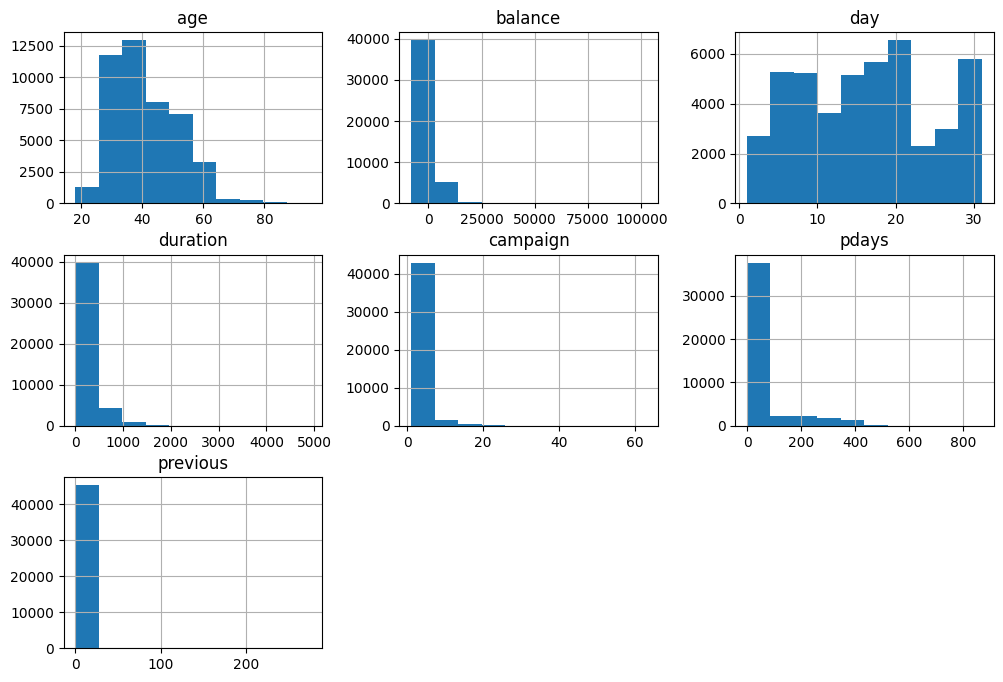

In [5]:
rcParams['figure.figsize'] = 12,8
plots = df.hist()

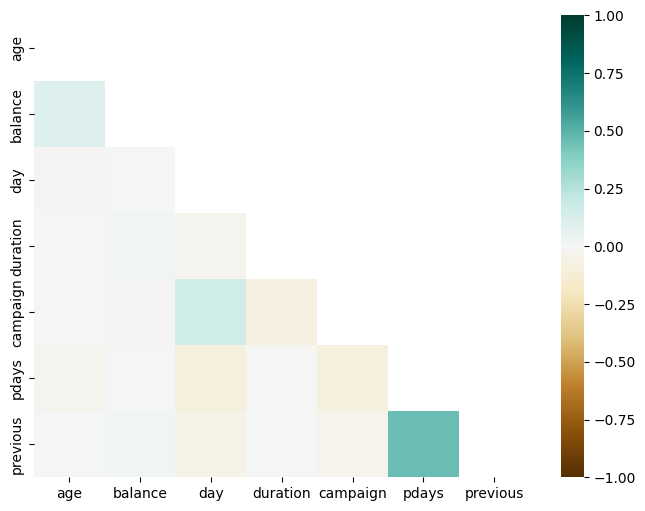

In [6]:
rcParams['figure.figsize'] = 8,6

sns.heatmap(df[['age','balance','day','duration','campaign','pdays','previous']].corr(), cmap="BrBG", vmin=-1, vmax=1, 
            mask = np.triu(df[['age','balance','day','duration','campaign','pdays','previous']].corr()))
plt.show()

In [7]:
### Change type of 'date' ###

parser = lambda x: datetime.datetime.strptime(x, '%d-%b-%Y')
dayoftheyear = (df.day.astype(str) + '-' + df.month.astype(str) + '-' + '1984').apply(parser).dt.dayofyear
dayoftheyear.head()
df = df.drop(columns=['day', 'month'])
df['dayoftheyear'] = dayoftheyear
df = df.drop('duration', axis = 1)

In [8]:
### Define cat/num columns ###

all_columns = df.columns
# ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'y', 'dayoftheyear']

categorical_features = [
                        'job', 
                        'marital', 
                        'education', 
                        'default',  
                        'housing', 
                        'loan', 
                        'contact', 
                        'poutcome'
                    ] 

numerical_features = [
                        'age', 
                        'balance', 
                        'campaign', 
                        'pdays', 
                        'dayoftheyear',
                        'previous'
                    ] 


categorical_features_an = [
                        'age', 
                        'balance', 
                        'campaign', 
                        'pdays',  
                        'dayoftheyear', 
                        'previous'
                    ] 

numerical_features_an = [
                        
                    ] 

target_column = 'y'

## Anonymise data

In [9]:
# env 8 min , k = 2
### Should choose which k we test ###

anonym_df = anonymisator(df,categorical_features, numerical_features, target_column, k=2)
anonym_df.head()

,age,balance,campaign,pdays,dayoftheyear,previous,y,count
0,20-25,139-167,1,-1-91,11-18,0-1,no,1
1,20-25,139-167,1,-1-91,11-18,0-1,yes,1
2,19-20,0-829,2-5,91-202,18-32,2-8,no,2
3,19-20,0-829,2-5,91-202,18-32,2-8,yes,1
4,35,-101-160,1,-1-345,107,0-4,no,5


In [84]:
# env 7 min , k = 3

anonym_df_k3 = anonymisator(df,categorical_features, numerical_features, target_column, k=2)
anonym_df_k3.head()

,age,balance,campaign,pdays,dayoftheyear,previous,y,count
0,20-25,139-167,1,-1-91,11-18,0-1,no,1
1,20-25,139-167,1,-1-91,11-18,0-1,yes,1
2,19-20,0-829,2-5,91-202,18-32,2-8,no,2
3,19-20,0-829,2-5,91-202,18-32,2-8,yes,1
4,35,-101-160,1,-1-345,107,0-4,no,5


In [10]:
# k = 2

ungrouped_anonym_df = ungroup_by_count(anonym_df)
ungrouped_anonym_df

,age,balance,campaign,pdays,dayoftheyear,previous,y
0,20-25,139-167,1,-1-91,11-18,0-1,no
1,20-25,139-167,1,-1-91,11-18,0-1,yes
2,19-20,0-829,2-5,91-202,18-32,2-8,no
3,19-20,0-829,2-5,91-202,18-32,2-8,no
4,19-20,0-829,2-5,91-202,18-32,2-8,yes
...,...,...,...,...,...,...,...
45206,38,59-323,1,-1,140,0,no
45207,53-59,1887-2262,8,-1,241,0,no
45208,53-59,1887-2262,8,-1,241,0,no
45209,57-65,2179-2236,7-8,-1-190,248-325,0-2,no


In [85]:
# k = 3

ungrouped_anonym_df_k3 = ungroup_by_count(anonym_df_k3)
ungrouped_anonym_df_k3

,age,balance,campaign,pdays,dayoftheyear,previous,y
0,20-25,139-167,1,-1-91,11-18,0-1,no
1,20-25,139-167,1,-1-91,11-18,0-1,yes
2,19-20,0-829,2-5,91-202,18-32,2-8,no
3,19-20,0-829,2-5,91-202,18-32,2-8,no
4,19-20,0-829,2-5,91-202,18-32,2-8,yes
...,...,...,...,...,...,...,...
45206,38,59-323,1,-1,140,0,no
45207,53-59,1887-2262,8,-1,241,0,no
45208,53-59,1887-2262,8,-1,241,0,no
45209,57-65,2179-2236,7-8,-1-190,248-325,0-2,no


### RESULT:

df - original data
    categorical_features
    numerical_features
    target_column

ungrouped_anonym_df - anonymised ungroupped data with target 'y'
    numerical_features (anonymised)
    target_column

In [86]:
print('---------------------------------------------------------------------------------------------------------------------------------------------- ')
display(ungrouped_anonym_df_k3.head())
print(f'Len ungrouped_anonym_df where k=3: {len(ungrouped_anonym_df)}')
print('---------------------------------------------------------------------------------------------------------------------------------------------- ')
display(ungrouped_anonym_df.head())
print(f'Len ungrouped_anonym_df where k=2: {len(ungrouped_anonym_df)}')
print('----------------------------------------------------------------------------------------------------------------------------------------------')
display(df.head())
print(f'Len df = {len(df)}')


---------------------------------------------------------------------------------------------------------------------------------------------- 


,age,balance,campaign,pdays,dayoftheyear,previous,y
0,20-25,139-167,1,-1-91,11-18,0-1,no
1,20-25,139-167,1,-1-91,11-18,0-1,yes
2,19-20,0-829,2-5,91-202,18-32,2-8,no
3,19-20,0-829,2-5,91-202,18-32,2-8,no
4,19-20,0-829,2-5,91-202,18-32,2-8,yes


Len ungrouped_anonym_df where k=3: 45211
---------------------------------------------------------------------------------------------------------------------------------------------- 


,age,balance,campaign,pdays,dayoftheyear,previous,y
0,20-25,139-167,1,-1-91,11-18,0-1,no
1,20-25,139-167,1,-1-91,11-18,0-1,yes
2,19-20,0-829,2-5,91-202,18-32,2-8,no
3,19-20,0-829,2-5,91-202,18-32,2-8,no
4,19-20,0-829,2-5,91-202,18-32,2-8,yes


Len ungrouped_anonym_df where k=2: 45211
----------------------------------------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,dayoftheyear
0,58,management,married,tertiary,no,2143,yes,no,unknown,1,-1,0,unknown,no,126
1,44,technician,single,secondary,no,29,yes,no,unknown,1,-1,0,unknown,no,126
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,-1,0,unknown,no,126
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,1,-1,0,unknown,no,126
4,33,unknown,single,unknown,no,1,no,no,unknown,1,-1,0,unknown,no,126


Len df = 45211


## Pipe lines

In [12]:

### Pipe lines creation ###

onehot_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])



pipeline = ColumnTransformer(
    transformers = [
         ("onehot", onehot_transformer, categorical_features), 
         ("numeric", numeric_transformer, numerical_features)
    ]) 

pipeline_an = ColumnTransformer(
    transformers = [
         ("onehot", onehot_transformer, categorical_features_an), 
         ("numeric", numeric_transformer, numerical_features_an)
    ],
    sparse_threshold=0.3) 

## (DT + RF) for original DF

In [13]:
### Encode categorical/ordinal features ###

X = df.copy()
y = X.pop('y')

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
X

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,dayoftheyear
0,58,management,married,tertiary,no,2143,yes,no,unknown,1,-1,0,unknown,126
1,44,technician,single,secondary,no,29,yes,no,unknown,1,-1,0,unknown,126
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,-1,0,unknown,126
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,1,-1,0,unknown,126
4,33,unknown,single,unknown,no,1,no,no,unknown,1,-1,0,unknown,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,3,-1,0,unknown,322
45207,71,retired,divorced,primary,no,1729,no,no,cellular,2,-1,0,unknown,322
45208,72,retired,married,secondary,no,5715,no,no,cellular,5,184,3,success,322
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,4,-1,0,unknown,322


In [15]:
### FIT - Transform original DF ### 

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Get feature names from the fitted OneHotEncoder and ordencoder
full_names = pipeline.get_feature_names_out()

# Convert the transformed NumPy array back to a DataFrame with proper column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns=full_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=full_names)

print('Train set:', X_train_transformed.shape)
print('Test set:', X_test_transformed.shape)

Train set: (36168, 38)
Test set: (9043, 38)


### Simple Decision Tree with original DF

In [16]:
# Decision Tree model creation 

# Define the parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_dt.fit(X_train_transformed, y_train)

# Print the best hyperparameters and their corresponding F1 score
print("Best hyperparameters: ", grid_search_dt.best_params_)
print("Best validation F1 score: ", grid_search_dt.best_score_)

# Test metrics
dt = DecisionTreeClassifier(**grid_search_dt.best_params_, class_weight='balanced')
dt.fit(X_train_transformed, y_train)
y_pred_dt = dt.predict(X_test_transformed)
f1_dt = f1_score(y_test, y_pred_dt)
print("Test F1 score: ", f1_dt)

Best hyperparameters:  {'max_depth': 5, 'min_samples_split': 10}
Best validation F1 score:  0.42120733766655294
Test F1 score:  0.42857142857142855


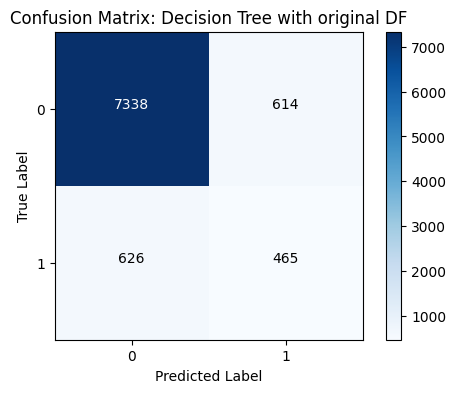

Classification Report for Decision Tree with original DF:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7952
           1       0.43      0.43      0.43      1091

    accuracy                           0.86      9043
   macro avg       0.68      0.67      0.68      9043
weighted avg       0.86      0.86      0.86      9043



In [30]:
plot_classification_results(y_test, y_pred_dt, classifier_name='Decision Tree with original DF')

#### Random Forest with original DF

In [18]:
# Random Forest model creation

# Define the parameter gridr
param_grid_forest = {
    'n_estimators': [25, 50, 100], 
    'max_depth': [5, 10, 15]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight = 'balanced_subsample'),
    param_grid=param_grid_forest,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_transformed, y_train)

# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best validation f1: ", grid_search.best_score_)

# Test metrics
rf = RandomForestClassifier(**grid_search.best_params_, class_weight = 'balanced_subsample')
rf.fit(X_train_transformed, y_train)
y_pred_rf = rf.predict(X_test_transformed)
f1 = f1_score(y_test, y_pred_rf)
print("Test f1 score :", f1)

Best hyperparameters:  {'max_depth': 15, 'n_estimators': 100}
Best validation f1:  0.43536210548108506
Test f1 score : 0.4486557955046276


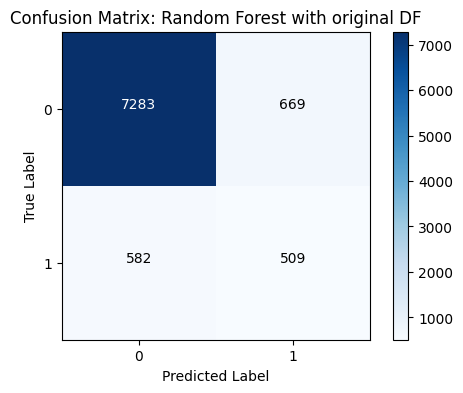

Classification Report for Random Forest with original DF:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7952
           1       0.43      0.47      0.45      1091

    accuracy                           0.86      9043
   macro avg       0.68      0.69      0.68      9043
weighted avg       0.87      0.86      0.86      9043



In [31]:
plot_classification_results(y_test, y_pred_rf, classifier_name='Random Forest with original DF')

## (DT + RF) for anonymised DF

In [55]:
### Encode categorical/ordinal features ###


# k = 2

data_an = ungrouped_anonym_df.copy()

X_an = data_an.drop('y', axis=1)
y_an = data_an['y']

X_an_encoded = pd.get_dummies(X_an)

le = LabelEncoder()
y_an = le.fit_transform(y_an)

X_train_an, X_test_an, y_train_an, y_test_an = train_test_split(X_an_encoded, y_an, test_size = 0.2, random_state = 42)

In [87]:
### Encode categorical/ordinal features ###


# k = 3

data_an_k3 = ungrouped_anonym_df_k3.copy()

X_an_k3 = data_an.drop('y', axis=1)
y_an_k3 = data_an['y']

X_an_encoded_k3 = pd.get_dummies(X_an_k3)

le = LabelEncoder()
y_an_k3 = le.fit_transform(y_an_k3)

X_train_an_k3, X_test_an_k3, y_train_an_k3, y_test_an_k3 = train_test_split(X_an_encoded_k3, y_an, test_size = 0.2, random_state = 42)

### Decision Tree with anonymised DF

In [ ]:
## 6 min env
# k = 2

# Define the parameter gridr
param_grid_dt_an = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
grid_search_dt_an = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_grid=param_grid_dt_an,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_dt_an.fit(X_train_an, y_train_an)

# Print the best hyperparameters and their corresponding F1 score
print("Best hyperparameters: ", grid_search_dt_an.best_params_)
print("Best validation F1 score: ", grid_search_dt_an.best_score_)

# Test metrics
dt_an = DecisionTreeClassifier(**grid_search_dt_an.best_params_, class_weight='balanced')
dt_an.fit(X_train_an, y_train_an)
y_pred_dt_an = dt_an.predict(X_test_an)
f1_dt_an = f1_score(y_test_an, y_pred_dt_an)
print("Test F1 score: ", f1_dt_an)

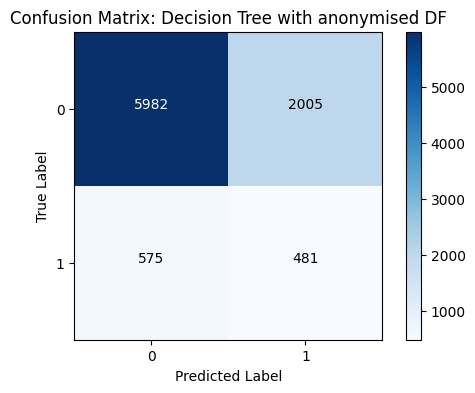

Classification Report for Decision Tree with anonymised DF:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      7987
           1       0.19      0.46      0.27      1056

    accuracy                           0.71      9043
   macro avg       0.55      0.60      0.55      9043
weighted avg       0.83      0.71      0.76      9043



In [66]:
# k = 2

plot_classification_results(y_test_an, y_pred_dt_an, classifier_name='Decision Tree with anonymised DF')

In [88]:
## 6 min env
# k = 3

# Define the parameter gridr
param_grid_dt_an_k3 = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
grid_search_dt_an_k3 = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_grid=param_grid_dt_an_k3,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_dt_an_k3.fit(X_train_an_k3, y_train_an_k3)

# Print the best hyperparameters and their corresponding F1 score
print("Best hyperparameters: ", grid_search_dt_an_k3.best_params_)
print("Best validation F1 score: ", grid_search_dt_an_k3.best_score_)

# Test metrics
dt_an_k3 = DecisionTreeClassifier(**grid_search_dt_an_k3.best_params_, class_weight='balanced')
dt_an_k3.fit(X_train_an_k3, y_train_an_k3)
y_pred_dt_an_k3 = dt_an_k3.predict(X_test_an_k3)
f1_dt_an_k3 = f1_score(y_test_an_k3, y_pred_dt_an_k3)
print("Test F1 score: ", f1_dt_an_k3)

c:\Users\eduard.vlasov\Documents\ethique-anonymisation\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eduard.vlasov\Documents\ethique-anonymisation\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eduard.vlasov\Documents\ethique-anonymisation\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Best hyperparameters:  {'max_depth': 10, 'min_samples_split': 10}
Best validation F1 score:  0.28863495303601483
Test F1 score:  0.2713681241184767


### Random Forest with anonymised DF

In [ ]:
## 6 min env
# k = 2

# Random Forest model creation

# Define the parameter gridr
param_grid_forest_an = {
    'n_estimators': [25, 50, 100], 
    'max_depth': [5, 10, 15]
}

# Create a GridSearchCV object
grid_search_an = GridSearchCV(
    estimator=RandomForestClassifier(class_weight = 'balanced_subsample'),
    param_grid=param_grid_forest_an,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_an.fit(X_train_an, y_train_an)

# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters: ", grid_search_an.best_params_)
print("Best validation f1: ", grid_search_an.best_score_)

# Test metrics
rf_an = RandomForestClassifier(**grid_search_an.best_params_, class_weight = 'balanced_subsample')
rf_an.fit(X_train_an, y_train_an)
y_pred_rf_an = rf_an.predict(X_test_an)
f1_an = f1_score(y_test_an, y_pred_rf_an)
print("Test f1 score :", f1_an)

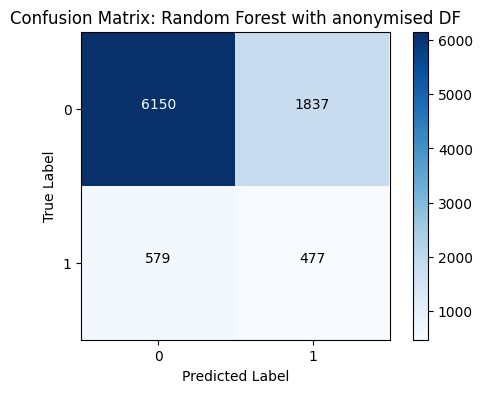

Classification Report for Random Forest with anonymised DF:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      7987
           1       0.21      0.45      0.28      1056

    accuracy                           0.73      9043
   macro avg       0.56      0.61      0.56      9043
weighted avg       0.83      0.73      0.77      9043



In [70]:
# k = 2

plot_classification_results(y_test_an, y_pred_rf_an, classifier_name='Random Forest with anonymised DF')

In [ ]:
## 5 min env
# k = 3

# Random Forest model creation

# Define the parameter gridr
param_grid_forest_an_k3 = {
    'n_estimators': [25, 50, 100], 
    'max_depth': [5, 10, 15]
}

# Create a GridSearchCV object
grid_search_an_k3 = GridSearchCV(
    estimator=RandomForestClassifier(class_weight = 'balanced_subsample'),
    param_grid=param_grid_forest_an_k3,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search_an_k3.fit(X_train_an_k3, y_train_an_k3)

# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters: ", grid_search_an_k3.best_params_)
print("Best validation f1: ", grid_search_an_k3.best_score_)

# Test metrics
rf_an_k3 = RandomForestClassifier(**grid_search_an_k3.best_params_, class_weight = 'balanced_subsample')
rf_an_k3.fit(X_train_an_k3, y_train_an_k3)
y_pred_rf_an_k3 = rf_an_k3.predict(X_test_an_k3)
f1_an_k3 = f1_score(y_test_an_k3, y_pred_rf_an_k3)
print("Test f1 score :", f1_an_k3)

In [91]:
results = [
    (y_test, y_pred_dt),
    (y_test, y_pred_rf),
    (y_test_an, y_pred_dt_an),
    (y_test_an, y_pred_rf_an)
]
classifier_names = [
    'DT original DF',
    'RF original DF',
    'DT anonymised DF (k=2)',
    'RF anonymised DF (k=2)'
]

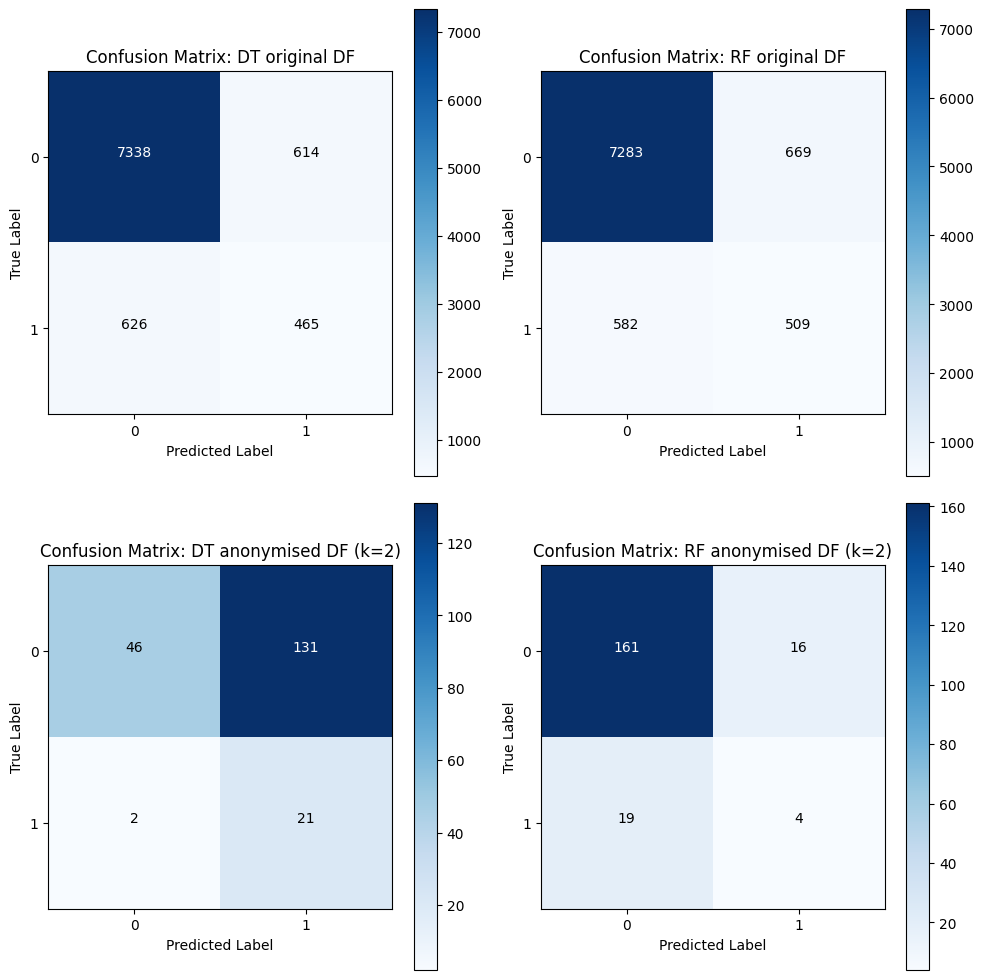

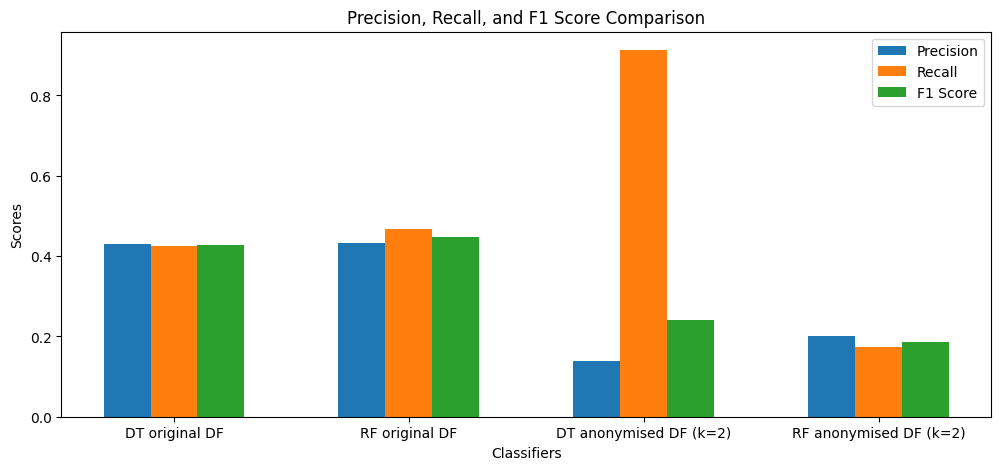

Classification Report for DT original DF:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7952
           1       0.43      0.43      0.43      1091

    accuracy                           0.86      9043
   macro avg       0.68      0.67      0.68      9043
weighted avg       0.86      0.86      0.86      9043

Classification Report for RF original DF:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7952
           1       0.43      0.47      0.45      1091

    accuracy                           0.86      9043
   macro avg       0.68      0.69      0.68      9043
weighted avg       0.87      0.86      0.86      9043

Classification Report for DT anonymised DF (k=2):
              precision    recall  f1-score   support

           0       0.96      0.26      0.41       177
           1       0.14      0.91      0.24        23

    accuracy                           0.34     

In [83]:
plot_classification_results_subplots(results, classifier_names)